# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data

In [2]:
rg3 = pd.read_csv("../data/processed/labeled_data_rg3.csv", parse_dates=True)

In [3]:
rg3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TimeStamp                 1256 non-null   object 
 1   Clamp_Close_Time          1256 non-null   float64
 2   Barrel_Temperature_4      1256 non-null   float64
 3   Hopper_Temperature        1256 non-null   float64
 4   Reason                    1256 non-null   object 
 5   Injection_Time            1256 non-null   float64
 6   Barrel_Temperature_1      1256 non-null   float64
 7   Plasticizing_Time         1256 non-null   float64
 8   Max_Back_Pressure         1256 non-null   float64
 9   Filling_Time              1256 non-null   float64
 10  Max_Injection_Pressure    1256 non-null   float64
 11  Plasticizing_Position     1256 non-null   float64
 12  Barrel_Temperature_6      1256 non-null   float64
 13  Cushion_Position          1256 non-null   float64
 14  Max_Inje

# 2. Data Preprocessing

In [4]:
# Preparation of features for model training
numerical_features = [x for x in rg3.columns if np.dtype(rg3[x]) == "float64"]

In [5]:
# Data for passed parts
rg3_Y = rg3[rg3["PassOrFail"] == 0]
rg3_Y = rg3_Y[numerical_features]
print("No. of passed RG3 parts:", len(rg3_Y))

No. of passed RG3 parts: 1224


In [6]:
# Data for failed parts
rg3_N = rg3[rg3["PassOrFail"] == 1]
rg3_N = rg3_N[numerical_features]
print("No. of failed RG3 parts:", len(rg3_N))

No. of failed RG3 parts: 32


In [7]:
# The model using Mahalanobis Distance is trained by Data for passed parts (i.e., data with a majority class)
rg3_train_Y, rg3_test_Y = train_test_split(rg3_Y, test_size=0.1)

# Test set with failed parts
rg3_test_N = rg3_N

print(f"No. of Train Set (Passed Parts): {len(rg3_train_Y)}")
print(f"No. of Test Set (Passed Parts): {len(rg3_test_Y)}")
print(f"No. of Test Set (Failed Parts): {len(rg3_test_N)}")

No. of Train Set (Passed Parts): 1101
No. of Test Set (Passed Parts): 123
No. of Test Set (Failed Parts): 32


In [8]:
# Data normalization

scaler = StandardScaler()

rg3_train_Y = scaler.fit_transform(rg3_train_Y)
rg3_test_Y = scaler.transform(rg3_test_Y)
rg3_test_N = scaler.transform(rg3_test_N)

# 3. Mahalanobis Distance

In [9]:
def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data.T)
        # cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()  # Can't understand why .diagonal() is used

In [10]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1] - 1) # df = degree of freedom
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

# 4. Setup of Threshold

In [11]:
clf = MahalanobisOneclassClassifier(rg3_train_Y, significance_level=0.1)

Critical value is:  30.813282343953027


In [12]:
threshold = clf.critical_value

# 5. Classification of Test Set by Mahalanobis Distance

## 5.1. Evaluation Using Test Set (Passed Parts)

In [13]:
# Prediction of Mahalanobis Distance
rg3_MD_Y = clf.predict_proba(rg3_test_Y)

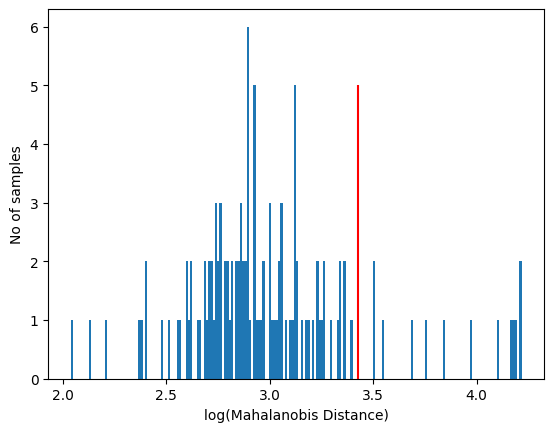

In [14]:
# Data Visualization 
# Log was used for better visualization

plt.hist(np.log(rg3_MD_Y), bins=200)
plt.xlabel("log(Mahalanobis Distance)")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 5, color="red")
plt.show();

In [15]:
# Check on the data that were predicted as failed parts

rg3_test_Y_anomalies = rg3_MD_Y > threshold
print("No. of Failed Parts:", np.sum(rg3_test_Y_anomalies))
print("Accuracy:", (rg3_test_Y.shape[0]-np.sum(rg3_test_Y_anomalies))/rg3_test_Y.shape[0])

No. of Failed Parts: 14
Accuracy: 0.8861788617886179


## 5.2. Evaluation Using Test Set (Failed Parts)

In [16]:
# Prediction of Mahalanobis Distance
rg3_MD_N = clf.predict_proba(rg3_test_N)

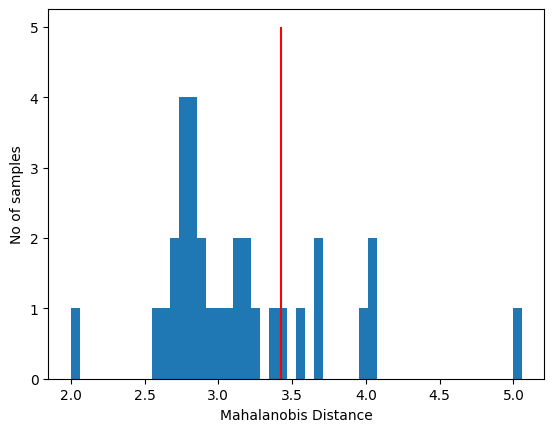

In [17]:
# Data visualization 
# Log was used for better visualization

plt.hist(np.log(rg3_MD_N), bins=50)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 5, color="red")
plt.show();

In [18]:
# Check on the data that were predicted as failed parts

rg3_test_N_anomalies = rg3_MD_N > threshold
print("No. of Failed Parts:", np.sum(rg3_test_N_anomalies))
print("Accuracy:", np.sum(rg3_test_N_anomalies)/rg3_test_N.shape[0])

No. of Failed Parts: 8
Accuracy: 0.25


# 6. Result Analysis

In [19]:
# True values for the test set

rg3_true = np.concatenate(
    [np.zeros(len(rg3_test_Y_anomalies)), np.ones(len(rg3_test_N_anomalies))]
)

In [20]:
# Predicted values for the test set

rg3_prediction = np.concatenate(
    [rg3_test_Y_anomalies, rg3_test_N_anomalies]
)

In [21]:
confusion_matrix(rg3_true, rg3_prediction)

array([[109,  14],
       [ 24,   8]], dtype=int64)

In [22]:
print(classification_report(rg3_true, rg3_prediction))

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       123
         1.0       0.36      0.25      0.30        32

    accuracy                           0.75       155
   macro avg       0.59      0.57      0.57       155
weighted avg       0.73      0.75      0.74       155



- While it was impossible to classify the failed parts using machine learning models, the model using Mahalanobis Distance could classify the passed and failed parts for `RG3` parts.
- However, the f1 score for `RG3` was much lower that that for `CN7`